### Import Relevant Libraries

In [28]:
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import pyodbc

### Loading the Data

#### Creating Connection to the Database

In [29]:
conn = pyodbc.connect(r'Driver=SQL Server;Server=.\SQLEXPRESS;Database=Project;Trusted_Connection=yes;')
cursor= conn.cursor()

#### Read the Data from the DataBase

In [30]:
data = pd.read_sql_query(
'''select * from kaggle.FlipkartReview''',conn
)


data_df = pd.DataFrame(data)
print(data_df.head())

                                              review  rating
0  It was nice produt. I like it's design a lot. ...     5.0
1  awesome sound....very pretty to see this nd th...     5.0
2  awesome sound quality. pros 7-8 hrs of battery...     4.0
3  I think it is such a good product not only as ...     5.0
4  awesome bass sound quality very good bettary l...     5.0


### Exploratory Data Analysis

In [31]:
data_df.isnull().sum()

review    0
rating    0
dtype: int64

The dataset does not have any null values

### Data Cleaning

In [32]:
import nltk
import re
nltk.download('stopwords')
stemmer = nltk.SnowballStemmer("english")
from nltk.corpus import stopwords
import string

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [33]:
stopword=set(stopwords.words('english'))

#### Cleaning the column containing review

In [34]:
def clean(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = [word for word in text.split(' ') if word not in stopword]
    text = " ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text = " ".join(text)
    return text

data_df['review'] = data_df['review'].apply(clean)

### Sentiment Analysis of the reviews

Each reviewer's ratings are listed in the **rating** column of the data. So let's look at how most customers rank the items they purchase from Flipkart.

In [35]:
ratings = data_df['rating'].value_counts()
ratings

5.0    5726
4.0    2365
3.0     884
1.0     691
2.0     310
Name: rating, dtype: int64

Majority of customers rated gave a very high rating to the product, more than half of customers gave ratings of 4.0 and 5.0

In [36]:
numbers = ratings.index
numbers

Float64Index([5.0, 4.0, 3.0, 1.0, 2.0], dtype='float64')

In [37]:
quantity = ratings.values
quantity

array([5726, 2365,  884,  691,  310], dtype=int64)

#### Visualizing the distribution of the ratings using pie chat

In [38]:
import plotly.express as px
figure = px.pie(data_df, values=quantity,
               names=numbers, hole = 0.5)
figure.show()

Therefore, 60% of reviewers gave the Flipkart products they purchased a 5 out of 5 star rating. Let's now examine the kind of reviews that people write. For this, I'll employ a word cloud to represent the words that appear most frequently in the reviews column:

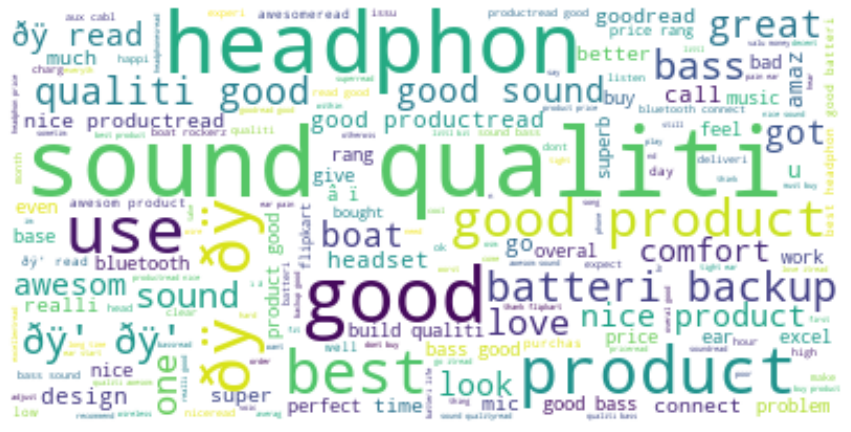

In [39]:
text = " ".join(i for i in data_df.review)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords = stopwords,
                     background_color = "white").generate(text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

By adding three columns to this dataset and labeling them Positive, Negative, and Neutral, I will now examine the feelings of the reviews on Flipkart by computing the sentiment scores of the reviews.

In [40]:
nltk.download('vader_lexicon')
sentiments = SentimentIntensityAnalyzer()
data_df['Positive'] = [sentiments.polarity_scores(i)['pos'] for i in data_df['review']]
data_df['Negative'] = [sentiments.polarity_scores(i)['neg'] for i in data_df['review']]
data_df['Neutral'] = [sentiments.polarity_scores(i)['neu'] for i in data_df['review']]
data_df = data_df[['review', 'Positive', 'Negative', 'Neutral']]
print(data_df.head())

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


                                              review  Positive  Negative  \
0  nice produt like design lot  easi carri   look...     0.431     0.000   
1  awesom soundveri pretti see nd sound qualiti g...     0.471     0.000   
2  awesom sound qualiti pros  hrs batteri life in...     0.194     0.000   
3  think good product per qualiti also design qui...     0.393     0.049   
4  awesom bass sound qualiti good bettari long li...     0.260     0.000   

   Neutral  
0    0.569  
1    0.529  
2    0.806  
3    0.558  
4    0.740  


Let's now examine what the majority of reviewers believe about the goods and services offered by Flipkart.

In [41]:
x = sum(data_df['Positive'])
y = sum(data_df['Negative'])
z = sum(data_df['Neutral'])

def sentiment_score(a, b, c):
    if (a>b) and (a>c):
        print("Positive")
    elif (b>a) and (b>c):
        print("Negative")
    else:
        print("Neutral")
sentiment_score(x, y, z)

Neutral


Therefore, the majority of the reviews are **Neutral**. To draw a conclusion about customer reviews for Flipkart, let's look at the sum of the scores for the positive, negative, and neutral sentiments.

In [42]:
print("Positive: ", x)
print("Negative: ", y)
print("Neutral: ", z)

Positive:  3121.4500000000794
Negative:  373.6480000000001
Neutral:  6480.880999999996


### Conclusion

Therefore, the majority of reviewers are Neutral, and a minor percentage are Negative. Therefore, we may conclude that customers are happy with Flipkart's Products and Services